<a href="https://colab.research.google.com/github/SmritiReddyy/MLOps_OCR_Only/blob/main/CourtAccess_Merged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CourtAccess AI — Unified Document Processing Pipeline

**Handles:** Digital PDFs, Scanned PDFs, OCR'd Scans, Handwritten, Mixed documents

**Pipeline:** Upload → Classify → Extract → Reconstruct → Compare

**Classification uses vector drawings as key distinguisher:**
- Digital PDFs have borders/lines/boxes as vector drawings
- Scanned PDFs have ZERO vector drawings — everything is pixels
- OCR'd scans have text spans + image but no vector drawings

In [ ]:
%%capture
!pip install numpy==1.26.4
!pip install pymupdf
!pip install paddlepaddle==2.6.2
!pip install paddleocr==2.8.1
!pip install langchain-community
!pip install Pillow scipy
!pip install pytesseract
!apt-get install -qq tesseract-ocr > /dev/null 2>&1
!pip install transformers torch
!pip install pydantic>=2.0

In [ ]:
import os, sys, tempfile
os.environ["PADDLE_PDX_DISABLE_MODEL_SOURCE_CHECK"] = "True"

import torch
import pymupdf
import numpy as np
from PIL import Image, ImageDraw
from scipy.ndimage import sobel
from IPython.display import display, Image as IPImage
import pytesseract

# PaddleOCR
PaddleOCR = None
try:
    from paddleocr import PaddleOCR
    print("✅ PaddleOCR: available")
except Exception as e:
    PaddleOCR = None
    print(f"⚠️ PaddleOCR unavailable: {e}")
    print("   Will use Tesseract for printed scans.")

# TrOCR
trocr_processor = None
trocr_model = None
try:
    from transformers import TrOCRProcessor, VisionEncoderDecoderModel
    print("⏳ Loading TrOCR (handwriting model)...")
    trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
    trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
    trocr_model.eval()
    if torch.cuda.is_available():
        trocr_model = trocr_model.to("cuda")
        print("✅ TrOCR: loaded (GPU)")
    else:
        print("✅ TrOCR: loaded (CPU — will be slow)")
except Exception as e:
    print(f"⚠️ TrOCR unavailable: {e}")
    print("   Will use Tesseract for handwritten pages.")

print("\n✅ All imports ready")

✅ PaddleOCR: available
⏳ Loading TrOCR (handwriting model)...


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/478 [00:00<?, ?it/s]

VisionEncoderDecoderModel LOAD REPORT from: microsoft/trocr-base-handwritten
Key                         | Status  | 
----------------------------+---------+-
encoder.pooler.dense.weight | MISSING | 
encoder.pooler.dense.bias   | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ TrOCR: loaded (GPU)

✅ All imports ready


In [ ]:
FONT_MAP = {
    "Helvetica": "helv", "Helvetica-Bold": "hebo",
    "Helvetica-Oblique": "heit", "Helvetica-BoldOblique": "hebi",
    "Times-Roman": "tiro", "Times-Bold": "tibo",
    "Times-Italic": "tiit", "Times-BoldItalic": "tibi",
    "Courier": "cour", "Courier-Bold": "cobo",
    "Courier-Oblique": "coit", "Courier-BoldOblique": "cobi",
    "Symbol": "symb", "ZapfDingbats": "zadb",
}

OCR_DPI = 300
OCR_CONFIDENCE = 0.5


def get_font_code(span):
    fontname = span.get("font", "")
    flags = span.get("flags", 0)
    direct = FONT_MAP.get(fontname)
    if direct:
        return direct
    is_bold = bool(flags & 16) or "bold" in fontname.lower()
    is_italic = bool(flags & 2) or "italic" in fontname.lower() or "oblique" in fontname.lower()
    is_mono = bool(flags & 8) or "courier" in fontname.lower() or "mono" in fontname.lower()
    is_serif = bool(flags & 4) or "times" in fontname.lower() or "serif" in fontname.lower() or "nimbus" in fontname.lower()
    if is_mono:
        return "cobi" if is_bold and is_italic else "cobo" if is_bold else "coit" if is_italic else "cour"
    elif is_serif:
        return "tibi" if is_bold and is_italic else "tibo" if is_bold else "tiit" if is_italic else "tiro"
    else:
        return "hebi" if is_bold and is_italic else "hebo" if is_bold else "heit" if is_italic else "helv"


def estimate_fontsize(text, target_width, fontname="helv"):
    font = pymupdf.Font(fontname)
    best_size = 5
    for s10 in range(50, 260, 2):
        size = s10 / 10.0
        w = font.text_length(text, fontsize=size)
        if w <= target_width:
            best_size = size
        else:
            break
    return best_size


print("✅ Font mapping & utilities ready")

✅ Font mapping & utilities ready


In [ ]:
def classify_page(page):
    td = page.get_text("dict", flags=pymupdf.TEXTFLAGS_TEXT)
    span_count = 0
    for b in td["blocks"]:
        if b["type"] == 0:
            for line in b["lines"]:
                for span in line["spans"]:
                    if span["text"].strip():
                        span_count += 1

    images = page.get_images(full=True)
    drawings = page.get_drawings()

    page_area = page.rect.width * page.rect.height
    total_img_area = 0
    has_large_image = False
    for img in images:
        try:
            for r in page.get_image_rects(img[0]):
                total_img_area += r.width * r.height
        except:
            pass
    if total_img_area == 0:
        for b in td["blocks"]:
            if b["type"] == 1:
                bbox = b["bbox"]
                total_img_area += (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    if total_img_area == 0 and images:
        for img in images:
            if img[2] > 1000 and img[3] > 1000:
                has_large_image = True
                total_img_area = page_area * 0.9
                break
    img_coverage = total_img_area / page_area if page_area > 0 else 0

    is_scanned = False
    page_type = "DIGITAL"
    is_handwritten = False

    if span_count == 0 and len(images) == 0:
        page_type = "BLANK"
    elif span_count > 10 and len(drawings) > 5:
        page_type = "DIGITAL"
    elif span_count > 10 and len(drawings) < 5 and (img_coverage > 0.3 or has_large_image or len(images) > 0):
        is_scanned = True
        page_type = "OCR'd SCAN"
    elif span_count > 10 and len(images) == 0:
        page_type = "DIGITAL"
    elif img_coverage > 0.3 or has_large_image or (len(images) > 0 and span_count < 10):
        is_scanned = True
        pix = page.get_pixmap(dpi=200)
        img_pil = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
        gray = np.array(img_pil.convert("L"))
        hw_score = _handwriting_score(gray)
        if hw_score > 0.6:
            page_type = "HANDWRITTEN"
            is_handwritten = True
        else:
            page_type = "SCANNED"
    elif page.get_text().strip() and len(page.get_text().strip()) > 50:
        page_type = "DIGITAL"
    else:
        is_scanned = True
        page_type = "SCANNED"

    return {
        "is_scanned": is_scanned,
        "page_type": page_type,
        "is_handwritten": is_handwritten,
        "span_count": span_count,
        "images": len(images),
        "drawings": len(drawings),
        "img_coverage": round(img_coverage * 100, 1),
    }


def _handwriting_score(gray) -> float:
    edges = np.hypot(sobel(gray.astype(float), axis=1), sobel(gray.astype(float), axis=0))
    stroke_var = edges.std() / (edges.mean() + 1e-6)
    row_density = np.mean(gray < 128, axis=1)
    active = row_density[row_density > 0.01]
    baseline_irreg = (active.std() / (active.mean() + 1e-6)) if len(active) > 1 else 0.5
    col_density = np.mean(gray < 128, axis=0)
    active_c = col_density[col_density > 0.01]
    spacing_irreg = (active_c.std() / (active_c.mean() + 1e-6)) if len(active_c) > 1 else 0.5
    score = (
        0.35 * min(stroke_var / 2.0, 1.0) +
        0.35 * min(baseline_irreg / 1.5, 1.0) +
        0.30 * min(spacing_irreg / 1.5, 1.0)
    )
    return min(max(score, 0.0), 1.0)


print("✅ Page classifier ready")

✅ Page classifier ready


In [ ]:
def reconstruct_digital_page(page):
    td = page.get_text("dict", flags=pymupdf.TEXTFLAGS_TEXT)
    all_spans = []
    for block in td["blocks"]:
        if block["type"] != 0:
            continue
        for line in block["lines"]:
            for span in line["spans"]:
                if span["text"].strip():
                    all_spans.append(span)

    for span in all_spans:
        page.add_redact_annot(pymupdf.Rect(span["bbox"]), fill=(1, 1, 1))
    page.apply_redactions(images=pymupdf.PDF_REDACT_IMAGE_NONE)

    count = 0
    for span in all_spans:
        origin = pymupdf.Point(span["origin"])
        color = pymupdf.sRGB_to_rgb(span["color"])
        fnt = get_font_code(span)
        text = span["text"]
        try:
            page.insert_text(origin, text, fontsize=span["size"], fontname=fnt, color=color)
            count += 1
        except:
            page.insert_text(origin, text, fontsize=span["size"], fontname="helv", color=color)
            count += 1
    return count


def reconstruct_scanned_page_paddle(page, ocr_engine):
    zoom = OCR_DPI / 72
    pix = page.get_pixmap(matrix=pymupdf.Matrix(zoom, zoom))
    tmp = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
    tmp.write(pix.tobytes("png"))
    tmp.close()
    result = ocr_engine.ocr(tmp.name, cls=True)
    os.unlink(tmp.name)

    detections = result[0] if result and result[0] else []
    if not detections:
        return 0

    scale_x = page.rect.width / pix.width
    scale_y = page.rect.height / pix.height
    shape = page.new_shape()
    regions = []
    for det in detections:
        text, conf = det[1][0], det[1][1]
        if conf < OCR_CONFIDENCE or not text.strip():
            continue
        xs = [p[0] for p in det[0]]
        ys = [p[1] for p in det[0]]
        rect = pymupdf.Rect(min(xs)*scale_x-1, min(ys)*scale_y-1,
                            max(xs)*scale_x+1, max(ys)*scale_y+1)
        regions.append({"rect": rect, "text": text})
        shape.draw_rect(rect)
        shape.finish(color=None, fill=(1, 1, 1))
    shape.commit(overlay=True)

    count = 0
    for r in regions:
        fontsize = estimate_fontsize(r["text"], r["rect"].width)
        fontsize = max(5, min(fontsize, r["rect"].height * 0.9))
        origin = pymupdf.Point(r["rect"].x0, r["rect"].y0 + r["rect"].height * 0.78)
        try:
            page.insert_text(origin, r["text"], fontsize=fontsize, fontname="helv", color=(0,0,0))
            count += 1
        except:
            pass
    return count


def reconstruct_scanned_page_tesseract(page):
    zoom = OCR_DPI / 72
    pix = page.get_pixmap(matrix=pymupdf.Matrix(zoom, zoom))
    img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    scale_x = page.rect.width / pix.width
    scale_y = page.rect.height / pix.height
    lines = {}
    for i in range(len(data["text"])):
        text = data["text"][i].strip()
        conf = int(data["conf"][i])
        if conf < 30 or not text:
            continue
        key = (data["block_num"][i], data["line_num"][i])
        if key not in lines:
            lines[key] = {"texts": [], "x0": float("inf"), "y0": float("inf"), "x1": 0, "y1": 0}
        ln = lines[key]
        ln["texts"].append(text)
        x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        ln["x0"] = min(ln["x0"], x)
        ln["y0"] = min(ln["y0"], y)
        ln["x1"] = max(ln["x1"], x + w)
        ln["y1"] = max(ln["y1"], y + h)

    shape = page.new_shape()
    regions = []
    for ln in lines.values():
        text = " ".join(ln["texts"])
        rect = pymupdf.Rect(ln["x0"]*scale_x-1, ln["y0"]*scale_y-1,
                            ln["x1"]*scale_x+1, ln["y1"]*scale_y+1)
        regions.append({"rect": rect, "text": text})
        shape.draw_rect(rect)
        shape.finish(color=None, fill=(1, 1, 1))
    shape.commit(overlay=True)

    count = 0
    for r in regions:
        if not r["text"].strip():
            continue
        fontsize = estimate_fontsize(r["text"], r["rect"].width)
        fontsize = max(5, min(fontsize, r["rect"].height * 0.9))
        origin = pymupdf.Point(r["rect"].x0, r["rect"].y0 + r["rect"].height * 0.78)
        try:
            page.insert_text(origin, r["text"], fontsize=fontsize, fontname="helv", color=(0,0,0))
            count += 1
        except:
            pass
    return count


def reconstruct_handwritten_page(page):
    zoom = OCR_DPI / 72
    pix = page.get_pixmap(matrix=pymupdf.Matrix(zoom, zoom))
    img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    scale_x = page.rect.width / pix.width
    scale_y = page.rect.height / pix.height

    lines = {}
    for i in range(len(data["text"])):
        text = data["text"][i].strip()
        conf = int(data["conf"][i])
        if conf < 10 or not text:
            continue
        key = (data["block_num"][i], data["line_num"][i])
        if key not in lines:
            lines[key] = {"x0": float("inf"), "y0": float("inf"), "x1": 0, "y1": 0}
        ln = lines[key]
        x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        ln["x0"] = min(ln["x0"], x)
        ln["y0"] = min(ln["y0"], y)
        ln["x1"] = max(ln["x1"], x + w)
        ln["y1"] = max(ln["y1"], y + h)

    shape = page.new_shape()
    regions = []

    for key, ln in lines.items():
        pad = 10
        crop = img.crop((max(0, ln["x0"]-pad), max(0, ln["y0"]-pad),
                         min(img.width, ln["x1"]+pad), min(img.height, ln["y1"]+pad)))
        crop = crop.convert("RGB")

        if trocr_model is not None and trocr_processor is not None:
            try:
                device = next(trocr_model.parameters()).device
                pixel_values = trocr_processor(images=crop, return_tensors="pt").pixel_values.to(device)
                with torch.no_grad():
                    ids = trocr_model.generate(pixel_values)
                text = trocr_processor.batch_decode(ids, skip_special_tokens=True)[0]
            except:
                text = pytesseract.image_to_string(crop).strip()
        else:
            text = pytesseract.image_to_string(crop).strip()

        if not text.strip():
            continue

        rect = pymupdf.Rect(ln["x0"]*scale_x-1, ln["y0"]*scale_y-1,
                            ln["x1"]*scale_x+1, ln["y1"]*scale_y+1)
        regions.append({"rect": rect, "text": text})
        shape.draw_rect(rect)
        shape.finish(color=None, fill=(1, 1, 1))

    shape.commit(overlay=True)

    count = 0
    for r in regions:
        fontsize = estimate_fontsize(r["text"], r["rect"].width)
        fontsize = max(5, min(fontsize, r["rect"].height * 0.9))
        origin = pymupdf.Point(r["rect"].x0, r["rect"].y0 + r["rect"].height * 0.78)
        try:
            page.insert_text(origin, r["text"], fontsize=fontsize, fontname="helv", color=(0,0,0))
            count += 1
        except:
            pass
    return count


print("✅ Reconstruction functions ready (digital + printed scan + handwritten)")

✅ Reconstruction functions ready (digital + printed scan + handwritten)


In [ ]:
def reconstruct_digital_page(page):
    td = page.get_text("dict", flags=pymupdf.TEXTFLAGS_TEXT)
    all_spans = []
    for block in td["blocks"]:
        if block["type"] != 0:
            continue
        for line in block["lines"]:
            for span in line["spans"]:
                if span["text"].strip():
                    all_spans.append(span)

    for span in all_spans:
        page.add_redact_annot(pymupdf.Rect(span["bbox"]), fill=(1, 1, 1))
    page.apply_redactions(images=pymupdf.PDF_REDACT_IMAGE_NONE)

    count = 0
    for span in all_spans:
        origin = pymupdf.Point(span["origin"])
        color = pymupdf.sRGB_to_rgb(span["color"])
        fnt = get_font_code(span)
        text = span["text"]
        try:
            page.insert_text(origin, text, fontsize=span["size"], fontname=fnt, color=color)
            count += 1
        except:
            page.insert_text(origin, text, fontsize=span["size"], fontname="helv", color=color)
            count += 1
    return count


def _is_signature_region(text, conf, bbox_height, all_detections, det_index):
    """
    Detect if a region is likely a signature.
    Returns True if it should be preserved (not white-out).
    """
    text_lower = text.lower().strip()

    # Skip signature labels themselves (keep them)
    if "signature" in text_lower:
        return False

    # Check if this detection is near a "signature" label
    for other in all_detections:
        other_text = other[1][0].lower()
        if "signature" in other_text:
            # Get vertical distance
            other_ys = [p[1] for p in other[0]]
            this_ys = [p[1] for p in all_detections[det_index][0]]
            vertical_dist = abs(min(this_ys) - max(other_ys))
            # If within 150px vertically of a "signature" label
            if vertical_dist < 150:
                # And it's short text with medium-low confidence
                if len(text) < 20 and conf < 0.92:
                    return True

    # Very short text near bottom of page with cursive-like characteristics
    if len(text) < 15 and conf < 0.90 and bbox_height > 70:
        return True

    return False


def reconstruct_scanned_page_paddle(page, ocr_engine):
    zoom = OCR_DPI / 72
    pix = page.get_pixmap(matrix=pymupdf.Matrix(zoom, zoom))
    tmp = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
    tmp.write(pix.tobytes("png"))
    tmp.close()
    result = ocr_engine.ocr(tmp.name, cls=True)
    os.unlink(tmp.name)

    detections = result[0] if result and result[0] else []
    if not detections:
        return 0

    scale_x = page.rect.width / pix.width
    scale_y = page.rect.height / pix.height

    shape = page.new_shape()
    regions = []
    skipped_sigs = 0

    for i, det in enumerate(detections):
        text, conf = det[1][0], det[1][1]
        if conf < OCR_CONFIDENCE or not text.strip():
            continue

        bbox_px = det[0]
        bbox_height = max(p[1] for p in bbox_px) - min(p[1] for p in bbox_px)

        # Check if this is a signature — skip white-out if so
        if _is_signature_region(text, conf, bbox_height, detections, i):
            skipped_sigs += 1
            continue

        xs = [p[0] for p in bbox_px]
        ys = [p[1] for p in bbox_px]
        rect = pymupdf.Rect(min(xs)*scale_x-1, min(ys)*scale_y-1,
                            max(xs)*scale_x+1, max(ys)*scale_y+1)
        regions.append({"rect": rect, "text": text})
        shape.draw_rect(rect)
        shape.finish(color=None, fill=(1, 1, 1))

    shape.commit(overlay=True)

    count = 0
    for r in regions:
        fontsize = estimate_fontsize(r["text"], r["rect"].width)
        fontsize = max(5, min(fontsize, r["rect"].height * 0.9))
        origin = pymupdf.Point(r["rect"].x0, r["rect"].y0 + r["rect"].height * 0.78)
        try:
            page.insert_text(origin, r["text"], fontsize=fontsize, fontname="helv", color=(0,0,0))
            count += 1
        except:
            pass

    if skipped_sigs:
        print(f"      🖊️ Preserved {skipped_sigs} signature region(s)")
    return count


def reconstruct_scanned_page_tesseract(page):
    zoom = OCR_DPI / 72
    pix = page.get_pixmap(matrix=pymupdf.Matrix(zoom, zoom))
    img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    scale_x = page.rect.width / pix.width
    scale_y = page.rect.height / pix.height
    lines = {}
    for i in range(len(data["text"])):
        text = data["text"][i].strip()
        conf = int(data["conf"][i])
        if conf < 30 or not text:
            continue
        key = (data["block_num"][i], data["line_num"][i])
        if key not in lines:
            lines[key] = {"texts": [], "x0": float("inf"), "y0": float("inf"), "x1": 0, "y1": 0}
        ln = lines[key]
        ln["texts"].append(text)
        x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        ln["x0"] = min(ln["x0"], x)
        ln["y0"] = min(ln["y0"], y)
        ln["x1"] = max(ln["x1"], x + w)
        ln["y1"] = max(ln["y1"], y + h)

    shape = page.new_shape()
    regions = []
    for ln in lines.values():
        text = " ".join(ln["texts"])
        rect = pymupdf.Rect(ln["x0"]*scale_x-1, ln["y0"]*scale_y-1,
                            ln["x1"]*scale_x+1, ln["y1"]*scale_y+1)
        regions.append({"rect": rect, "text": text})
        shape.draw_rect(rect)
        shape.finish(color=None, fill=(1, 1, 1))
    shape.commit(overlay=True)

    count = 0
    for r in regions:
        if not r["text"].strip():
            continue
        fontsize = estimate_fontsize(r["text"], r["rect"].width)
        fontsize = max(5, min(fontsize, r["rect"].height * 0.9))
        origin = pymupdf.Point(r["rect"].x0, r["rect"].y0 + r["rect"].height * 0.78)
        try:
            page.insert_text(origin, r["text"], fontsize=fontsize, fontname="helv", color=(0,0,0))
            count += 1
        except:
            pass
    return count


def reconstruct_handwritten_page(page):
    zoom = OCR_DPI / 72
    pix = page.get_pixmap(matrix=pymupdf.Matrix(zoom, zoom))
    img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    scale_x = page.rect.width / pix.width
    scale_y = page.rect.height / pix.height
    lines = {}
    for i in range(len(data["text"])):
        text = data["text"][i].strip()
        conf = int(data["conf"][i])
        if conf < 10 or not text:
            continue
        key = (data["block_num"][i], data["line_num"][i])
        if key not in lines:
            lines[key] = {"x0": float("inf"), "y0": float("inf"), "x1": 0, "y1": 0}
        ln = lines[key]
        x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        ln["x0"] = min(ln["x0"], x)
        ln["y0"] = min(ln["y0"], y)
        ln["x1"] = max(ln["x1"], x + w)
        ln["y1"] = max(ln["y1"], y + h)

    shape = page.new_shape()
    regions = []
    for key, ln in lines.items():
        pad = 10
        crop = img.crop((max(0, ln["x0"]-pad), max(0, ln["y0"]-pad),
                         min(img.width, ln["x1"]+pad), min(img.height, ln["y1"]+pad)))
        crop = crop.convert("RGB")

        if trocr_model is not None and trocr_processor is not None:
            try:
                device = next(trocr_model.parameters()).device
                pixel_values = trocr_processor(images=crop, return_tensors="pt").pixel_values.to(device)
                with torch.no_grad():
                    ids = trocr_model.generate(pixel_values)
                text = trocr_processor.batch_decode(ids, skip_special_tokens=True)[0]
            except:
                text = pytesseract.image_to_string(crop).strip()
        else:
            text = pytesseract.image_to_string(crop).strip()

        if not text.strip():
            continue

        rect = pymupdf.Rect(ln["x0"]*scale_x-1, ln["y0"]*scale_y-1,
                            ln["x1"]*scale_x+1, ln["y1"]*scale_y+1)
        regions.append({"rect": rect, "text": text})
        shape.draw_rect(rect)
        shape.finish(color=None, fill=(1, 1, 1))

    shape.commit(overlay=True)

    count = 0
    for r in regions:
        fontsize = estimate_fontsize(r["text"], r["rect"].width)
        fontsize = max(5, min(fontsize, r["rect"].height * 0.9))
        origin = pymupdf.Point(r["rect"].x0, r["rect"].y0 + r["rect"].height * 0.78)
        try:
            page.insert_text(origin, r["text"], fontsize=fontsize, fontname="helv", color=(0,0,0))
            count += 1
        except:
            pass
    return count


print("✅ Reconstruction functions ready (with signature preservation)")

✅ Reconstruction functions ready (with signature preservation)


In [ ]:
def run_pipeline():
    from google.colab import files

    print("📤 Upload a PDF:\n")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded")
        return

    filename = list(uploaded.keys())[0]
    input_path = f"/content/{filename}"
    with open(input_path, 'wb') as f:
        f.write(uploaded[filename])

    print(f"\n{'='*60}")
    print(f"Processing: {filename}")
    print(f"{'='*60}")

    src_doc = pymupdf.open(input_path)
    out_doc = pymupdf.open()
    out_doc.insert_pdf(src_doc)
    src_doc.close()

    paddle_engine = None
    digital_pages = 0
    scanned_pages = 0
    handwritten_pages = 0
    blank_pages = 0

    for pg in range(len(out_doc)):
        out_page = out_doc[pg]
        info = classify_page(out_page)

        if info["page_type"] == "BLANK":
            print(f"\n⬜ Page {pg+1}/{len(out_doc)}: BLANK — skipping")
            blank_pages += 1

        elif info["page_type"] == "DIGITAL":
            print(f"\n📄 Page {pg+1}/{len(out_doc)}: DIGITAL "
                  f"({info['span_count']} spans, {info['drawings']} drawings)")
            count = reconstruct_digital_page(out_page)
            print(f"   ✅ Redacted & re-inserted {count} spans")
            digital_pages += 1

        elif info["is_handwritten"]:
            engine_name = "TrOCR" if trocr_model is not None else "Tesseract"
            print(f"\n✍️  Page {pg+1}/{len(out_doc)}: HANDWRITTEN → {engine_name}")
            count = reconstruct_handwritten_page(out_page)
            print(f"   ✅ {engine_name}: inserted {count} text regions")
            handwritten_pages += 1

        elif info["is_scanned"]:
            if PaddleOCR is not None:
                if paddle_engine is None:
                    print(f"\n   ⏳ Initializing PaddleOCR...")
                    paddle_engine = PaddleOCR(use_textline_orientation=True, lang='en')
                print(f"\n📷 Page {pg+1}/{len(out_doc)}: {info['page_type']} → PaddleOCR")
                count = reconstruct_scanned_page_paddle(out_page, paddle_engine)
                print(f"   ✅ PaddleOCR: inserted {count} text regions")
            else:
                print(f"\n📷 Page {pg+1}/{len(out_doc)}: {info['page_type']} → Tesseract")
                count = reconstruct_scanned_page_tesseract(out_page)
                print(f"   ✅ Tesseract: inserted {count} text regions")
            scanned_pages += 1

    output_path = f"/content/output_{filename}"
    out_doc.save(output_path)
    out_doc.close()

    print(f"\n{'='*60}")
    print(f"🎉 RECONSTRUCTION COMPLETE")
    print(f"   Digital pages:     {digital_pages}")
    print(f"   Scanned pages:     {scanned_pages}")
    print(f"   Handwritten pages: {handwritten_pages}")
    print(f"   Blank pages:       {blank_pages}")
    print(f"   Output: {output_path}")
    print(f"{'='*60}")

    print(f"\n{'='*60}")
    print("COMPARISON: Original vs Reconstructed")
    print(f"{'='*60}")
    show_comparison(input_path, output_path)

    files.download(output_path)
    print(f"\n✅ Downloaded: output_{filename}")


print("✅ Pipeline ready — run: run_pipeline()")

✅ Pipeline ready — run: run_pipeline()


📤 Upload a PDF:



Saving SML Application.pdf to SML Application (3).pdf

Processing: SML Application (3).pdf

   ⏳ Initializing PaddleOCR...
[2026/02/21 20:17:39] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/

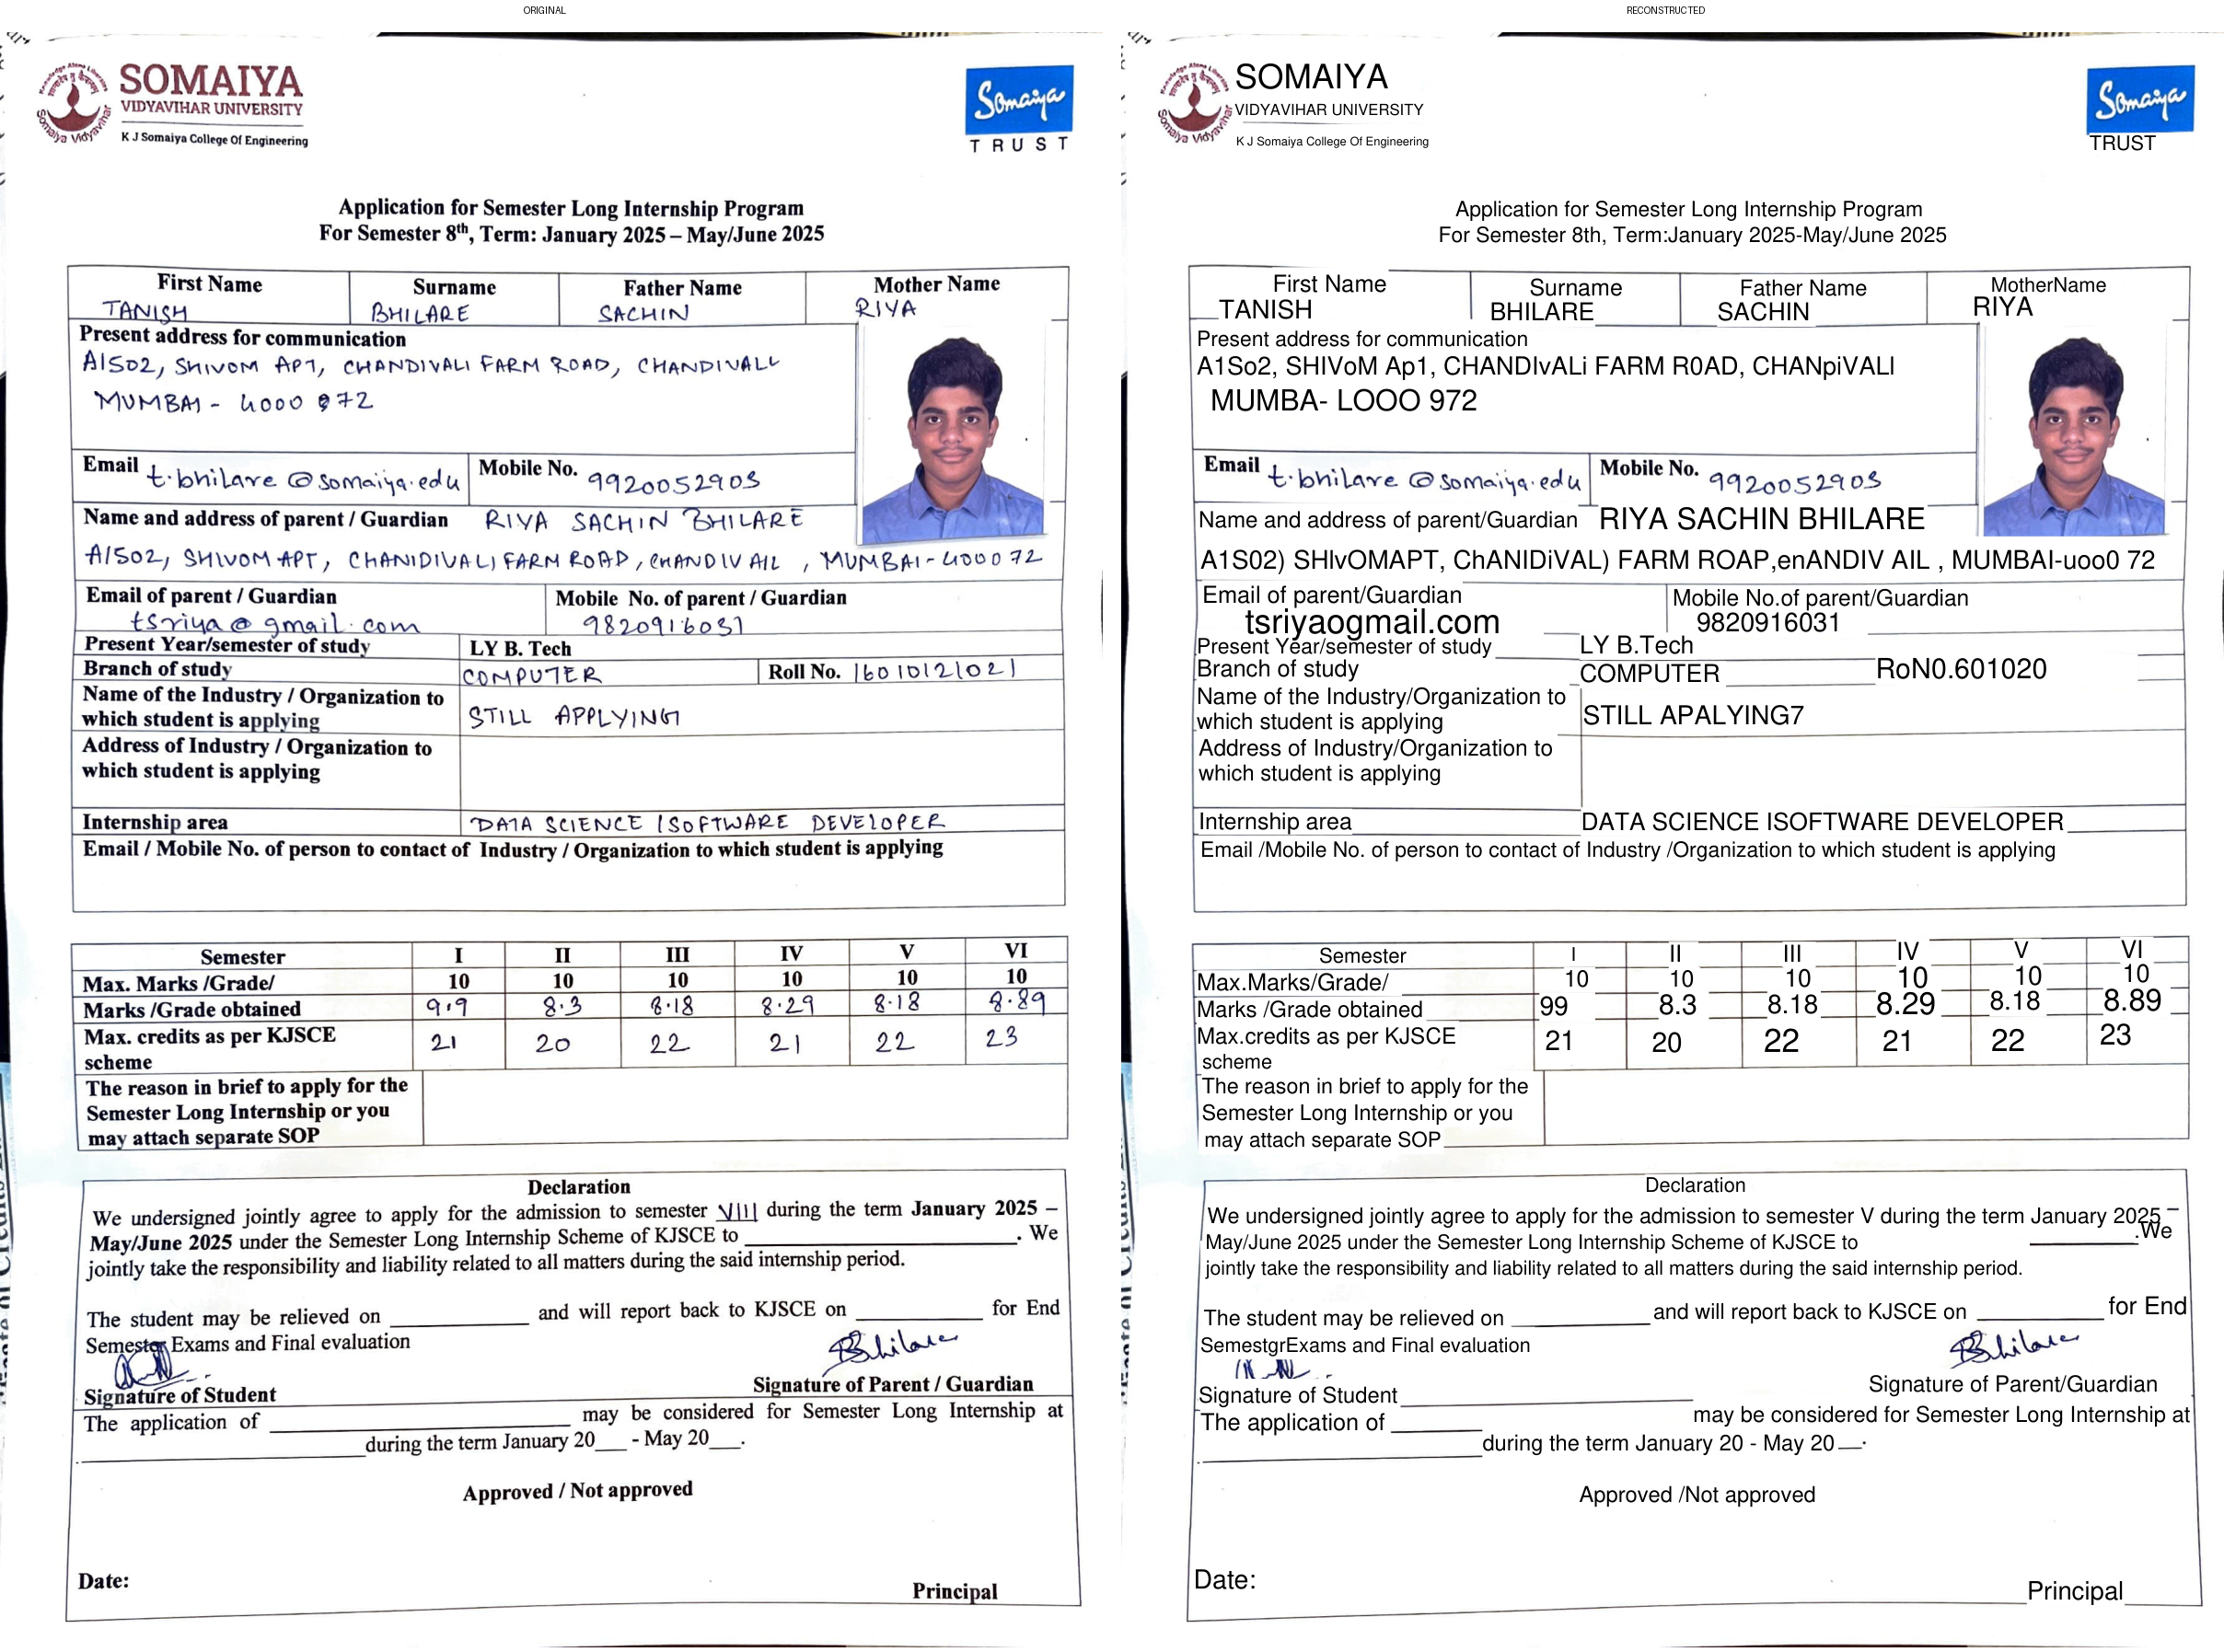

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Downloaded: output_SML Application (3).pdf


In [ ]:
# ============================================================
# CELL 8: RUN IT
# ============================================================
run_pipeline()